In [1]:
!pip install soynlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 6.6 MB/s eta 0:00:00


In [2]:
import urllib.request
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt", filename="2016-10-20.txt")

('2016-10-20.txt', <http.client.HTTPMessage at 0x7d4e97373970>)

In [4]:
corpus = DoublespaceLineCorpus("2016-10-20.txt")

In [5]:
word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

training was done. used memory 0.818 Gb
all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 361598
all accessor variety was computed # words = 361598


--------------------------------------------------------------------------------

In [6]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 44.5 MB/s eta 0:00:00


In [7]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [8]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import re
from konlpy.tag import Mecab
from gensim.parsing.preprocessing import preprocess_string
from tqdm import tqdm
import numpy as np
from konlpy.tag import Kkma
from gensim.models import LdaModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
from soynlp.tokenizer import MaxScoreTokenizer
from soynlp.word import WordExtractor

In [23]:
headers = {'User-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'}
search = input("검색어를 입력하세요:")
url = "https://www.riss.kr/search/Search.do?isDetailSearch=N&searchGubun=true&viewYn=OP&queryText=&strQuery=%EC%A0%84%EC%B2%98%EB%A6%AC&exQuery=&exQueryText=&order=%2FDESC&onHanja=false&strSort=RANK&p_year1=&p_year2=&iStartCount=0&orderBy=&mat_type=&mat_subtype=&fulltext_kind=&t_gubun=&learning_type=&ccl_code=&inside_outside=&fric_yn=&db_type=&image_yn=&gubun=&kdc=&ttsUseYn=&l_sub_code=&fsearchMethod=search&sflag=1&isFDetailSearch=N&pageNumber=1&resultKeyword=&fsearchSort=&fsearchOrder=&limiterList=&limiterListText=&facetList=&facetListText=&fsearchDB=&icate=re_a_kor&colName=re_a_kor&pageScale=217&isTab=Y&regnm=&dorg_storage=&language=&language_code=&clickKeyword=&relationKeyword=&query=" + search
r = requests.get(url)
soup = bs(r.text, 'html.parser')
contents = soup.find_all('div', class_='cont ml60')

def clean_text(text):
    text = text.replace(".", "").strip()
    text = text.replace("·", " ").strip()
    pattern = '[^ ㄱ-ㅣ가-힣]+'
    text = re.sub(pattern=pattern, repl='', string=text)
    return text

def words_tokenizer(text):
    kkma = Kkma()

    # 태깅
    words_ = kkma.pos(text)

    # 인덱싱
    words = [word[0] for word in words_ if word[1] == 'NNG']

    return words

def get_scores(texts):
    word_extractor = WordExtractor()
    word_extractor.train(texts)
    scores = word_extractor.word_scores()
    return scores

def korean_tokenizer(text):
    maxscore_tokenizer = MaxScoreTokenizer()
    tokens = maxscore_tokenizer.tokenize(text)
    return tokens

def preprocessing(d):
    return clean_text(d)

# 데이터 수집 및 전처리
texts = []
for cont in contents:
    abstract_text = cont.find('p', class_='preAbstract').text if cont.find('p', class_='preAbstract') else ''
    texts.append(abstract_text)

# scores 계산
scores = get_scores(texts)

title = []
writer = []
publisher = []
year = []
journal = []
link = []
abstracts = []

for cont in contents:
    title.append(cont.find('p', class_='title').text)
    writer.append(cont.find('span', class_='writer').text)
    publisher.append(cont.find('p', class_="etc").find_all('span')[1].text)
    year.append(cont.find('p', class_="etc").find_all('span')[2].text)
    journal.append(cont.find('p', class_="etc").find_all('span')[3].text)
    link.append('https://www.riss.kr'+ cont.find('p', class_='title').find('a')['href'])

    if cont.find('p', class_='preAbstract'):
        abstracts.append(cont.find('p', class_='preAbstract').text)
    else:
        abstracts.append('초록이 없습니다.')

# 데이터프레임 생성
df = pd.DataFrame(
    {
        'title': title,
        'writer': writer,
        'publisher': publisher,
        'year': year,
        'journal': journal,
        'link': link,
        'abstracts': abstracts

    }
)

# 연도별로 정렬
# 삭제하고자 하는 특정 단어
df['abstracts'] = df['abstracts'].str.strip()
df = df[df['abstracts'].str.lower() != '초록이 없습니다.']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



검색어를 입력하세요:인공지능
training was done. used memory 1.877 Gb
all cohesion probabilities was computed. # words = 5475
all branching entropies was computed # words = 8408
all accessor variety was computed # words = 8408


In [24]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,title,writer,publisher,year,journal,link,abstracts
0,인공지능 교사의 발전 수준에 따른 인공적 도덕행위자(AMA)의 역할에 대한 시론,방은찬(Eun Chan Bang),한국인공지능윤리학회,2022,인공지능윤리연구,https://www.riss.kr/search/detail/DetailView.d...,지금은 인공지능 시대라 부를 수 있을 정도로 인공지능 중심의 기술사회가 형성되고 있...
1,초중등 인공지능 교육을 위한 프레임워크 기초 연구,"김태령,류미영,한선관",한국인공지능교육학회,2020,인공지능연구 논문지,https://www.riss.kr/search/detail/DetailView.d...,본 연구는 초중등 인공지능 교육을 위한 프레임워크 기초 연구에 관한 것이다. 인공지...
2,초등학생 인공지능 윤리 인식 척도 개발,이혜령(Hye Ryeong Lee),한국인공지능윤리학회,2023,인공지능윤리연구,https://www.riss.kr/search/detail/DetailView.d...,인공지능 윤리교육을 효과적으로 설계하기 위해서는 학생들의 인공지능 윤리 인식 수준을...
3,인공지능 리터러시 함양을 위한 인공지능 융합 사회과 문제해결 수업모형 및 교수전략 ...,"구단희,김진현,이지영,조애영,이원희",한국인공지능교육학회,2022,인공지능연구 논문지,https://www.riss.kr/search/detail/DetailView.d...,본 연구의 목적은 인공지능 리터러시 함양을 위한 인공지능 융합 사회과 문제해결의 수...
4,인공지능 교육 프로그램 개발 및 적용을 통한 인공지능 역량·태도·인식 변화 분석,"이동열,한선관",한국인공지능교육학회,2022,인공지능연구 논문지,https://www.riss.kr/search/detail/DetailView.d...,"인공지능은 우리의 생활과 경제, 사회 등의 분야에서 폭넓게 변화를 이끌고 있으며, ..."
...,...,...,...,...,...,...,...
210,국내외 인공지능형 로봇 개발 및 시장 현황 연구,남미경(Mee Kyung Nam),한국디자인문화학회,2010,한국디자인문화학회지,https://www.riss.kr/search/detail/DetailView.d...,인공지능형 로봇은 산업적 측면에서 자동차산업 규모 이상의 성장 잠재력을 가지고 있어...
211,인공지능과 철학적 인간학,이진경(Yi-Jinkyung),경상대학교 사회과학연구원(마르크스주의 연구),2017,마르크스주의 연구,https://www.riss.kr/search/detail/DetailView.d...,이 논문은 인공지능이나 사이보그가 전통적 철학이나 인간학에 던지는 물음을 다루고자 ...
212,`인공지능`과 `인간지능` 개념에 대한 철학적 분석 시도,"김형주(Kim, Hyeongjoo)",중앙대학교 중앙철학연구소,2016,철학탐구,https://www.riss.kr/search/detail/DetailView.d...,본 논문은 ‘인공지능’이라는 개념을 처음 사용한 공학자인 존 맥카시의 ‘인공지능’에...
215,"인공지능 판사, 과연 가능한가?","강승식(Kang, Seungsik)",한국헌법학회,2020,憲法學硏究,https://www.riss.kr/search/detail/DetailView.d...,최근 4차 산업혁명시대를 맞아 법 영역에서 인공지능은 어디까지 발전할 것인가? 궁극...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

 16%|█▌        | 15/93 [00:00<00:00, 144.62it/s]

Title: 인공지능 교사의 발전 수준에 따른 인공적 도덕행위자의 역할에 대한 시론
Abstract: ['지금은', '인공지능 교육', '시대라', '부를', '수', '있을', '정도로', '인공지능 교육', '중심의', '기술사회가', '형성되고', '있다.', '이러한', '상황은', '교육에', '있어서도', '무관하지', '않으며', '인공지능 교육', '교사에', '대한', '기대가', '이를', '나타내고', '있다.', '인공지능 교육', '교사가', '앞으로', '어떻게', '발전할지를', '예측해보는', '것은', '인공지능 교육', '교사의', '발전', '방향성을', '제공하는', '역할을', '한다.', '그러므로', '본', '논문은', '인공지능 교육', '교사의', '발전', '수준을', '1수준부터', '5수준까지', '5가지', '기능항목에', '따라', '5가지', '단계로', '제시하였다.', '또한', '인공적', '도덕행위자로서의', '인공지능 교육', '교사가', '어떠한', '역할을', '할', '수', '있는가를', '논의하였다.', 'Now,', 'a', 'technologi', 'cal', 'society', 'centered', 'on', 'artificial', 'intelligen', 'ce', 'is', 'being', 'formed', 'to', 'the', 'extent', 'that', 'it', 'can', 'be', 'called', 'the', 'age', 'of', 'artificial', 'intelligen', 'ce.', 'This', 'situation', 'is', 'not', 'irrelevant', 'in', 'education,', 'and', 'expectatio', 'ns', 'for', 'artificial', 'intelligen', 'ce', 'teachers', 'are', 'showing', 'this.', 'Predicting', 'how', 'AI', 'teach

 51%|█████     | 47/93 [00:00<00:00, 138.59it/s]

Title: 인공지능철학 관련 연구의 비판적 고찰 통합이론 사상한과 관련하여
Abstract: ['거의', '모든', '학문', '영역에서', '전(全)방위적으로', '인공지능에', '대한', '연구가', '진행되고', '있다.', '인공지능 교육', '관련', '철학', '연구에', '있어서도', '많은', '연구물들이', '나오고', '있지만,', '상이한', '철학적', '관점으로', '동시에', '인공지능 교육', '문제에', '접근하는', '경우가', '적지', '않다.', '대립각을', '세웠던', '철학사상이', '동시에,', '동일한', '주제에', '적용되었을', '때', '상이한', '결론을', '도출하기', '마련이다.', '따라서', '‘상반되는', '철학적·윤리학적', '관점을', '적용했을', '때', '얻게', '될', '상이한', '결론은', '어떻게', '극복할', '수', '있는지?’를', '밝히는', '것이', '선결', '과제로', '남는다.', '본고에서는', '이에', '대한', '또', '하나의', '대안으로서', '통합적', '접근(Integra', 'ted', 'approach)', '을', '제안한다.', '국내외를', '막론하고', '인공지능에', '관한', '선행연구에서', '통합적', '접근법을', '사용하는', '연구물은', '찾기', '어렵다.', '하지만,', '통합적', '접근법은', '‘접근법으로서의', '개별철학사상의', '한계’,', '‘철학적', '관점의', '차이에', '따른', '결론의', '상이성’을', '잘', '보여준다.', '이에,', '통합적인', '모델', '‘사상한(四象限)’', '을', '원용하며,', '이를', '인공지능 교육', '문제에', '적용·응용할', '수', '있다는', '사실을', '적시한다.', 'Research', 'on', 'AI', 'is', 'under', 'way', 'in', 'almost', 'all', 'academic', 'fields.', 'W

 85%|████████▍ | 79/93 [00:00<00:00, 130.94it/s]

Title: 텍스트 마이닝 기법을 활용한 인공지능 기술개발 동향 분석 연구 깃허브 상의 오픈 소스 소프트웨어 프로젝트를 대상으로
Abstract: ['Artificial', 'intelligen', 'ce', '(AI)', 'is', 'one', 'of', 'the', 'main', 'driving', 'forces', 'leading', 'the', 'Fourth', 'Industrial', 'Revolution', '.', 'The', 'technologi', 'es', 'associated', 'with', 'AI', 'have', 'already', 'shown', 'superior', 'abilities', 'that', 'are', 'equal', 'to', 'or', 'better', 'than', 'people', 'in', 'many', 'fields', 'including', 'image', 'and', 'speech', 'recognitio', 'n.', 'Particular', 'ly,', 'many', 'efforts', 'have', 'been', 'actively', 'given', 'to', 'identify', 'the', 'current', 'technology', 'trends', 'and', 'analyze', 'developmen', 't', 'directions', 'of', 'it,', 'because', 'AI', 'technologi', 'es', 'can', 'be', 'utilized', 'in', 'a', 'wide', 'range', 'of', 'fields', 'including', 'medical,', 'financial,', 'manufactur', 'ing,', 'service,', 'and', 'education', 'fields.', 'Major', 'platforms', 'that', 'can', 'develop', 'complex', 'AI', 'algorithms', 'for', 'learni

100%|██████████| 93/93 [00:00<00:00, 128.84it/s]


Abstract: ['본', '논문에서는', '인공지능을', '이용해서', '엔진오일을', '자동으로', '교환시스템을', '제안', '하고자', '한다.', '모범운전자도,', '엔진오일을', '교환하는', '시기를', '정확하게', '예측하기란', '매우', '어렵다.', '왜냐하면', '엔진오일', '색깔이', '검은색이거나', '주행거리가', '300', '㎞', '이상이', '되었을때에', '엔진오일을', '교환해야만', '하는것이', '아니기', '때문이다', '최적의', '엔진오일', '교환시기를', '예측하기위해서는', '엔진오일', '색깔,', '엔진오일', '접도와', '도로조건,', '급제동및', '급발진', '조건을', '고려해야하기', '때문이다.', '그러므로', '본', '논문에서는', '이러한', '문제점을', '해결하기위해서', '퍼지규칙및', '신경망을', '이용해서', '엔진오일교환시기를', '예측하는', '전문가시스템을', '개발하였다.', 'This', 'paper', 'has', 'been', 'proposed', 'an', 'engine', 'oil', 'changing', 'system', 'automatica', 'lly', 'using', 'artificial', 'intelligen', 'ce.', 'As', 'you', 'know,', 'It', 'is', 'very', 'difficult', 'to', 'forecast', 'the', 'time', 'that', 'exchange', 'engine', 'oil', 'exactly.', 'Because,', 'It', 'does', 'not', 'necessary', 'to', 'change', 'the', 'engine', 'oil', 'when', 'color', 'of', 'engine', 'is', 'black', 'or', 'distance', 'is', 'more', 'than', '3000', '㎞.', 'In', 'order', 'to', 'fo

<ipython-input-28-6329a312423d>:68: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

<ipython-input-28-6329a312423d>:68: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

<ipython-input-28-6329a312423d>:68: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

<ipython-input-28-6329a312423d>:68: MatplotlibDeprecationW

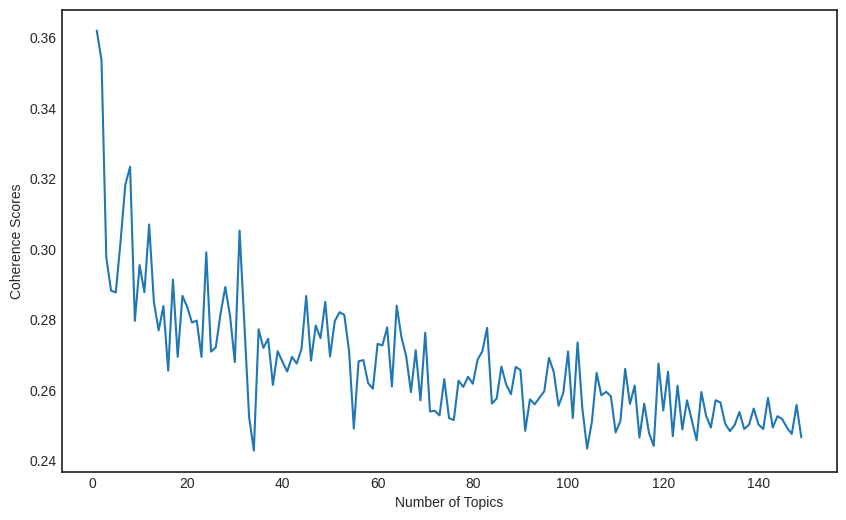

In [28]:
# 데이터프레임 순회 및 토크나이징
for index, row in tqdm(df.iterrows(), total=len(df)):
    title = clean_text(row['title'])
    abstracts = row['abstracts']  # Assuming 'abstracts' is the column name

    # Check if the abstract is not empty before printing
    abstract_tokens = korean_tokenizer(abstracts)

    # Custom rule to replace '인공지능' with '인공지능 교육'
    abstract_tokens = [token if token != '인공지능' else '인공지능 교육' for token in abstract_tokens]

    if abstract_tokens and abstract_tokens[0] == '초록':
        continue
    else:
        print(f"Title: {title}")
        print(f"Abstract: {abstract_tokens}")
        print("-" * 30)

def preprocessing(text):
    return words_tokenizer(text)

df['tokenized_news'] = df['abstracts'].apply(preprocessing)
tokenized = df['tokenized_news'].to_list()

# Assuming you already have tokenized data in 'tokenized'
dictionary = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=10, no_above=5)
corpus = [dictionary.doc2bow(text) for text in tokenized]

num_topics = 40
chunksize = 500
passes = 40
iterations = 400
eval_every = None

temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics

from gensim.models.coherencemodel import CoherenceModel

min_topics, max_topics = 1,150
coherence_scores = []

for num_topics in range(min_topics, max_topics):
  model = LdaModel(corpus, num_topics = num_topics, id2word=dictionary)
  coherence = CoherenceModel(model = model,
                             texts = tokenized,
                             dictionary = dictionary)
  coherence_scores.append(coherence.get_coherence())

  plt.style.use('seaborn-white')

x = [i for i in range(min_topics, max_topics)]

plt.figure(figsize=(10,6))
plt.plot(x,coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.show()

In [29]:
lda_model = LdaModel(corpus, num_topics=38, id2word=dictionary)
topics = lda_model.print_topics(num_topics=38)
topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[(0,
  '0.126*"데이터" + 0.122*"학습" + 0.085*"구축" + 0.059*"이용" + 0.044*"인" + 0.041*"제안" + 0.040*"영역" + 0.039*"경우" + 0.036*"대상" + 0.035*"구성"'),
 (1,
  '0.127*"기술" + 0.096*"서비스" + 0.061*"연구" + 0.061*"인공지능" + 0.059*"제안" + 0.044*"시스템" + 0.032*"활용" + 0.030*"분야" + 0.030*"가능성" + 0.027*"분석"'),
 (2,
  '0.122*"인공지능" + 0.087*"기술" + 0.065*"분석" + 0.048*"연구" + 0.044*"교육" + 0.035*"개발" + 0.020*"인식" + 0.020*"산업" + 0.020*"결과" + 0.015*"프로그램"'),
 (3,
  '0.190*"연구" + 0.099*"인공지능" + 0.057*"분석" + 0.045*"교육" + 0.032*"텍스트" + 0.030*"논문" + 0.028*"의미" + 0.023*"특성" + 0.022*"자료" + 0.022*"기술"'),
 (4,
  '0.182*"데이터" + 0.094*"인공지능" + 0.059*"기준" + 0.056*"알고리즘" + 0.044*"제시" + 0.037*"과정" + 0.037*"방법" + 0.037*"발생" + 0.036*"발전" + 0.035*"검증"'),
 (5,
  '0.126*"시스템" + 0.111*"방식" + 0.110*"인식" + 0.075*"활용" + 0.074*"이용" + 0.067*"인공지능" + 0.043*"알고리즘" + 0.042*"점" + 0.042*"과" + 0.040*"제안"'),
 (6,
  '0.145*"교육" + 0.107*"프로그램" + 0.097*"인공지능" + 0.096*"적용" + 0.065*"개발" + 0.049*"연구" + 0.044*"활용" + 0.039*"향상" + 0.030*"문제" + 0.027*"실시"'),
 (7

In [30]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



--------------------------------------------------------------------------------

In [14]:
!pip install dash pandas plotly

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 15.0 MB/s eta 0:00:00


In [15]:
!pip install konlpy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
!pip install soynlp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from konlpy.tag import Kkma
from soynlp.tokenizer import MaxScoreTokenizer
from soynlp.word import WordExtractor

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Dash 앱 생성
app = dash.Dash(__name__)

# 슬라이더의 최소, 최대 값 설정
min_year = 2000
max_year = 2023

app.layout = html.Div([
    dcc.Input(
        id='search-input',
        type='text',
        value=search,
        placeholder='검색어를 입력하세요...',
        style={'width': '50%'}
    ),
    dcc.Slider(
        id='year-slider',
        min=min_year,
        max=max_year,
        step=1,
        value=min_year,
        marks={str(year): str(year) for year in range(min_year, max_year+1)},
    ),
    dcc.Graph(id='output-graph'),
])


@app.callback(
    Output('output-graph', 'figure'),
    [Input('search-input', 'value'),
     Input('year-slider', 'value')]
)
def update_graph(search_term, selected_year):
    filtered_df = df[(df['year'] == str(selected_year)) & (df['title'].str.contains(search_term, case=False))]

    fig = {
        'data': [
            {'x': filtered_df['title'], 'y': filtered_df['year'], 'type': 'bar', 'name': 'Year-wise Publications'},
        ],
        'layout': {
            'title': f'Publications for the Year {selected_year}',
            'xaxis': {'title': 'Title'},
            'yaxis': {'title': 'Year'},
        }
    }

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>